In [69]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

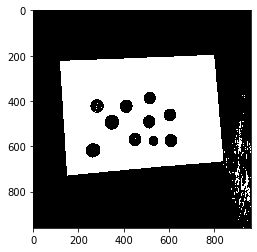

In [76]:
#image 흑백처리, 이진화 (그냥 Threshold)

img = cv2.imread('money.jpg')
img_ori = img.copy()
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


#배경과 종이의 색감 차이에 따라 threshold값 다르게 줄 것 (평균 170)
ret_threshold, binary_img = cv2.threshold(img_gray, 170, 255, cv2.THRESH_BINARY_INV)
#A4를 쓸 경우 활성화 
binary_img=cv2.bitwise_not(binary_img)


plt.imshow(binary_img, cmap='gray')

#블러처리 후 threshold(adapted threshold)

img_blurred = cv2.GaussianBlur(img_gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

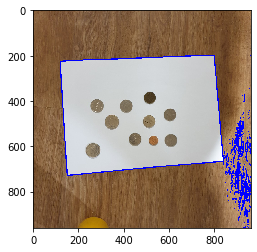

In [77]:
#contour을 찾고 A4용지의 외곽선 그리기
img, contour, hierarchy = cv2.findContours(binary_img, 
                                            cv2.RETR_EXTERNAL, 
                                            cv2.CHAIN_APPROX_SIMPLE)

img = img_ori.copy()

# Draw Contour with Blue
cv2.drawContours(img, contour, -1, (255,0,0), 3)
plt.figure()
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

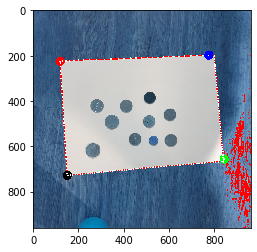

In [78]:
#그려진 외곽선을 바탕으로 꼭짓점 찾기 (perspective point)

cnt=contour[-1]

#좌표점의 순서는 빨->검->파->녹
leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])
topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])

# 좌표 표시하기
cv2.circle(img,leftmost,20,(255,0,0),-1) #빨강
cv2.circle(img,rightmost,20,(0,255,0),-1) #녹색
cv2.circle(img,topmost,20,(0,0,255),-1) #파랑
cv2.circle(img,bottommost,20,(0,0,0),-1) #검정

img = cv2.drawContours(img, cnt, -1, (255,255,255), 5)

plt.imshow(img)

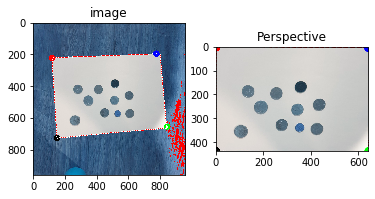

In [83]:
#prospective Transform
#pts1 = np.float32([topmost,leftmost,rightmost,bottommost])
pts1 = np.float32([leftmost,bottommost,topmost,rightmost])

# 좌표의 이동점
pts2 = np.float32([[0,0],[0,437],[640,0],[640,437]])

M = cv2.getPerspectiveTransform(pts1, pts2)

dst = cv2.warpPerspective(img, M, (640,437))


plt.subplot(121),plt.imshow(img),plt.title('image')
plt.subplot(122),plt.imshow(dst),plt.title('Perspective')
plt.show()

cv2.imshow('img',dst)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [84]:
#0
image = dst
cv2.imshow("result",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
cv2.imshow("result",gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

edge = cv2.Canny(gray,50,150)
cv2.imshow("result",edge)
cv2.waitKey(0)
cv2.destroyAllWindows()

#1
edge = cv2.bitwise_not(edge)
cv2.imshow("result",edge)
cv2.waitKey(0)
cv2.destroyAllWindows()

contours = cv2.findContours(edge.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(edge,contours[1],-1,(0,0,0),3)
cv2.imshow("result",edge)
cv2.waitKey(0)
cv2.destroyAllWindows()

#2
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(edge)

for i in range(nlabels):
    if i<2:
        continue
    
    area = stats[i,cv2.CC_STAT_AREA]
    center_x = int(centroids[i,0])
    center_y = int(centroids[i,1])
    left = stats[i,cv2.CC_STAT_LEFT]
    top = stats[i,cv2.CC_STAT_TOP]
    width = stats[i,cv2.CC_STAT_WIDTH]
    height = stats[i,cv2.CC_STAT_HEIGHT]
    
    if area>50:
        cv2.rectangle(img,(left,top),(left + width, top+height),
                      (0,0,255),1)
        cv2.circle(img,(center_x,center_y),5,(255,0,0),1)
        cv2.putText(img,str(i),(left+20,top+20),
                   cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
        
cv2.imshow("result",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [85]:
import cv2
import numpy as np

img = dst
img = cv2.medianBlur(img,7)
cimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(cimg, cv2.HOUGH_GRADIENT, 1, 20,param1=100,param2=50,minRadius=0, maxRadius=0)

circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

cv2.imshow('img', cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [86]:
# 컬러 이미지를 저장할 넘파이 배열을 생성합니다.
#width = 500
#height = 500
#bpp = 3

#img = np.zeros((height, width, bpp), np.uint8)
#cimg = cv2.cvtColor(cimg,cv2.COLOR_GRAY2BGR)

for i in circles[0,:]:
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),1)  #그냥 테두리
    cv2.circle(cimg,(i[0],i[1]),35,(0,0,255),1)  #100원
    cv2.circle(cimg,(i[0],i[1]),40,(255,0,0),1) #500원 
    
    
    
# (250,250)이 중심인 반지름 10인 파란색으로 채워진 원을 그립니다.
#cv2.circle(cimg, (i[0], i[1]), i[2], (255, 0, 0), 1)

# (250,250)이 중심인 반지름이 100인 선굵기가 1인 빨간색 원을 그립니다.  
#cv2.circle(cimg, (i[0], i[1]), 2, (0, 0, 255), 3)


cv2.imshow("result", cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [87]:
import cv2 
import numpy as np 

img = dst
img = cv2.medianBlur(img, 5) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 15, param1 = 200, param2 = 30)[0] 

dbg_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8) 
count500 = 0
count100 = 0 
for c in circles: 
    print('Detected circle: center = ({} {}), radius = {}'.format(c[0],c[1],c[2]))
    if(c[2] > 36) :
        cv2.circle(dbg_img, (c[0], c[1]), c[2], (255,0,0), 2)
        count500 +=1
    
    elif(c[2] < 36) :
        cv2.circle(dbg_img, (c[0], c[1]), c[2], (0,0,255), 2)
        count100 +=1
    
#for i in circles[0,:]:
 #   cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),1)  #그냥 테두리
  #  cv2.circle(cimg,(i[0],i[1]),[33:36],(0,0,255),1)  #100원
   # cv2.circle(cimg,(i[0],i[1]),[37:42],(255,0,0),1) #500원 
    
cv2.imshow('img', img) 
cv2.imshow('dbg_img', dbg_img) 
cv2.waitKey() 
cv2.destroyAllWindows()



Detected circle: center = (187.5 253.5), radius = 28.899999618530273
Detected circle: center = (133.5 186.5), radius = 26.399999618530273
Detected circle: center = (339.5 263.5), radius = 25.700000762939453
Detected circle: center = (252.5 194.5), radius = 25.700000762939453
Detected circle: center = (103.5 352.5), radius = 28.600000381469727
Detected circle: center = (353.5 167.5), radius = 24.5
Detected circle: center = (349.5 339.5), radius = 19.600000381469727
Detected circle: center = (274.5 327.5), radius = 26.0
Detected circle: center = (431.5 243.5), radius = 27.100000381469727
Detected circle: center = (423.5 346.5), radius = 27.399999618530273


In [16]:
print(count500*500 + count100*100, "원")

1200 원
